## IMPORTS AND PARAMETERS

In [10]:
from IPython.display import clear_output
from datetime import datetime
from tqdm import tqdm
import cv2
import numpy as np

from data import DataLoader, SessionMetrics
from models import Models

import tensorflow as tf
import tensorflow.keras.backend as K# type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
import gc

In [11]:
TRAIN_DATASET_PATH = "./src/train/"
VAL_DATASET_PATH = "./src/val/"

METRICS_PATH = "./training/checkpoint.txt"
OUTPUTS_PATH ="./training/output"

GENERATOR_SAVE_PATH = "./training/generator"
DISCRIMINATOR_SAVE_PATH = "./training/discriminator"
GAN_OPTIMIZER_SAVE_PATH ="./training/opt_gan"
DISC_OPTIMIZER_SAVE_PATH ="./training/opt_disc"

MANUEL_PARAM_PATH = "./training/manuel_params.txt"
IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNEL = (128,128,3)
DATA_LENGTH = 14628
METRIC_SAVE_PERIOT = 1
MODEL_SAVE_PERIOT = 2
BATCH_SIZE = 16
BATH_COUNT = int(DATA_LENGTH / BATCH_SIZE)
TRAIN_TOPIC = ""
LATENT_DIM = 20  
NUM_CLASSES = 3  

In [12]:
def read_manuel_params(path):
    f = open(path,"r")
    line = f.readline()
    f.close()
    end_epoch = None
    save_periot = None

    words = line.split(" ")
    for i,word in enumerate(words):
        if i == 0:
            end_epoch = int(word.split(":")[1])
        elif i == 1:
            save_periot = int(word.split(":")[1])
                
    return end_epoch,save_periot

In [13]:
models = Models((IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_CHANNEL),NUM_CLASSES,LATENT_DIM)
models.build_models()
generator = models.generator
discriminator = models.discriminator
gan = models.gan

Compile Process Ended.
Discriminator learning rate:  <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-05>
GAN learning rate:  <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0002>
Model: "gan"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 generator (Functional)         (None, 128, 128, 3)  149375      ['input_5[0][0]',                
                                                                  'input_6[0][0]']  

In [14]:
session_metrics =SessionMetrics(METRIC_SAVE_PERIOT)

## DATA

Loading data from:  ./src/train/
Found 14624 files belonging to 3 classes.
Data loaded successfully.
Images scaled to [0,1].
CURRENT DATASET SCALE: True
IMAGE TYPE: float32


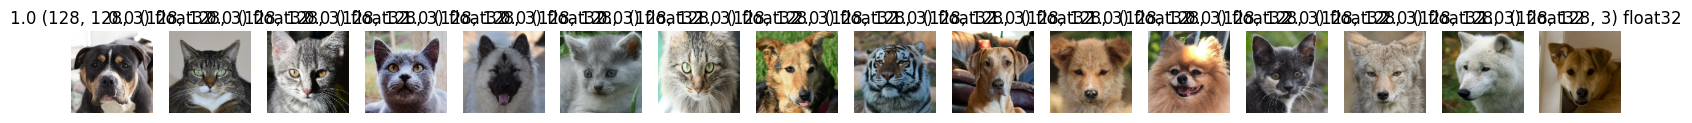

In [15]:
dataloader = DataLoader(batch_size=BATCH_SIZE,image_size=(IMAGE_WIDTH,IMAGE_HEIGHT))
data = dataloader.load_data(TRAIN_DATASET_PATH)
#data = data.take(20)
dataloader.show_sample(1)

## TRAINING

In [16]:
def get_random_latent_vector():
    """
    Get random latent vector    
    :return:
        Random normal distrubition vector with (BATCH_SIZE,LATENT_DIM) shape 
    """
    return np.random.normal(0,1,(BATCH_SIZE,LATENT_DIM))

def get_random_labels():
    """
    Get random class labels
    :return:
        integer class vector, shape:(BATCH_SIZE)
    """
    return np.random.randint(0,NUM_CLASSES,BATCH_SIZE)

def get_test_input():
    """
    Get static test samples
    :return:
        :noise: Noise, It has (3,LATENT_DIM) shape and his values between 0 and 1
        :label: static numpy array->[0,1,2]
    """
    noise = np.random.normal(0,1,(BATCH_SIZE,LATENT_DIM))
    label = np.array([0,0,0,0,1,1,1,1,2,2,2,2,0,1,2,0])
    return noise,label

def get_inter_test_sample(generated_images,labels):
    """
    Getting line test outputs
    :input:
        :generated_images: predicted images via generator from noises
        :labels: predicted labels
    """
    batch,height,width,channel = generated_images.shape
    output = np.zeros((height*int(batch / 4),width*4,channel))
    generated_images = np.reshape(generated_images,(int(batch/4),4,height,width,channel))
    labels = np.reshape(labels,(int(batch/4),4))
    for i , row in enumerate(generated_images):
        for j , im in enumerate(row):
            output[i*height:(i+1)*height,j*width:(j+1)*width] = np.uint8(DataLoader.descale_im(im,i)[0])    
            cv2.putText(output,str(labels[i][j]),(30 + j*width,80 + i*height),cv2.FONT_HERSHEY_DUPLEX,2.5,(255,0,0),1)

    return output.astype(np.uint8)
                    
def train(gan,discriminator,generator,data,session_metrics,test_noise,test_label):
    """
    Train process of gan model
    :input:
        :discriminator: Discriminator model
        :generator: Generator model
        :data: dataset (tf.Dataset)
        :session_metrics: Showing outputs and saving inter model process follower (Process())
        :test_noise: The test noise, which will be predict and show every epoch
        :test_label: The test label, which will be predict and show every epoch
    """
    
    real = np.ones((BATCH_SIZE,1))
    fake = np.zeros((BATCH_SIZE,1))
    
    quarter_batch_count = int(BATH_COUNT / 4)
    epoch = 0
    while True:  
        print(f"EPOCH {epoch} SESSION")  
        TRAIN_TOPIC = datetime.now().strftime("%m_%d-%H_%M")
        end_epoch,MODEL_SAVE_PERIOT = read_manuel_params(MANUEL_PARAM_PATH)
        
        if end_epoch == epoch:
            print("Training ended.")
            break
        
        tf.keras.backend.clear_session()
        
        mean_d_loss_fake = 0
        mean_d_loss_real = 0
        mean_g_loss = 0
        batch_counter = 0
        for batch,i in zip(data,tqdm(range(BATH_COUNT))):
            
            images,labels = batch
    
            # train generator via gan model, data goes through noise->predicted->1 (as real)
            noise = get_random_latent_vector()
            random_labels = get_random_labels()
            g_loss = gan.train_on_batch([noise,random_labels],real)
          
            d_loss_real = 0
            d_loss_fake = 0
            if epoch % 3 == 0:

                #train discriminator with real data
                d_loss_real = discriminator.train_on_batch([images,labels],real)
                
                # train discriminator with fake data
                noise = get_random_latent_vector()
                random_labels = get_random_labels()
                gen_imgs = generator.predict([noise,random_labels],verbose=None)
                d_loss_fake = discriminator.train_on_batch([gen_imgs,random_labels],fake) 
                        

                      
            #metrics
            mean_d_loss_fake += d_loss_fake
            mean_d_loss_real += d_loss_real
            mean_g_loss += g_loss
            batch_counter +=1
            
            if i in [quarter_batch_count,quarter_batch_count*2,quarter_batch_count*3]:
                print(f"BATCH {i}")
                
                print("d_loss_fake: ",mean_d_loss_fake/batch_counter," d_loss_real: ",mean_d_loss_real/batch_counter," g_loss: ",mean_g_loss/batch_counter)
                
            
            

        clear_output() 
        print(f"EPOCH {epoch} OUTPUTS")
        
        # metrics for epoch
        mean_g_loss = mean_g_loss / batch_counter
        mean_d_loss_fake = mean_d_loss_fake / batch_counter
        mean_d_loss_real =  mean_d_loss_real / batch_counter
        
        # inter test sample
        gnrtd_imgs = models.test_generator(test_noise,test_label)
        inter_test_sample = get_inter_test_sample(gnrtd_imgs,test_label)
        
        session_metrics.save_checkpoint(epoch,TRAIN_TOPIC,mean_d_loss_real,mean_d_loss_fake,mean_g_loss,inter_test_sample,METRICS_PATH,OUTPUTS_PATH)
        session_metrics.show_outputs(mean_d_loss_real,mean_d_loss_fake,mean_g_loss,epoch,inter_test_sample)
        if epoch % MODEL_SAVE_PERIOT == 0:
            models.save_models(TRAIN_TOPIC,epoch,GENERATOR_SAVE_PATH,DISCRIMINATOR_SAVE_PATH,GAN_OPTIMIZER_SAVE_PATH,DISC_OPTIMIZER_SAVE_PATH)
            
        print("D_LOSS_REAL",mean_d_loss_real)
        print("D_LOSS_FAKE",mean_d_loss_fake)
        print("G_LOSS",mean_g_loss)
        gc.collect()
        K.clear_session()
        epoch += 1

        
    

## TRAIN

In [17]:
test_noises,test_labels = get_test_input()

EPOCH 1 OUTPUTS
1/1 [==============================] - 0s 21ms/step


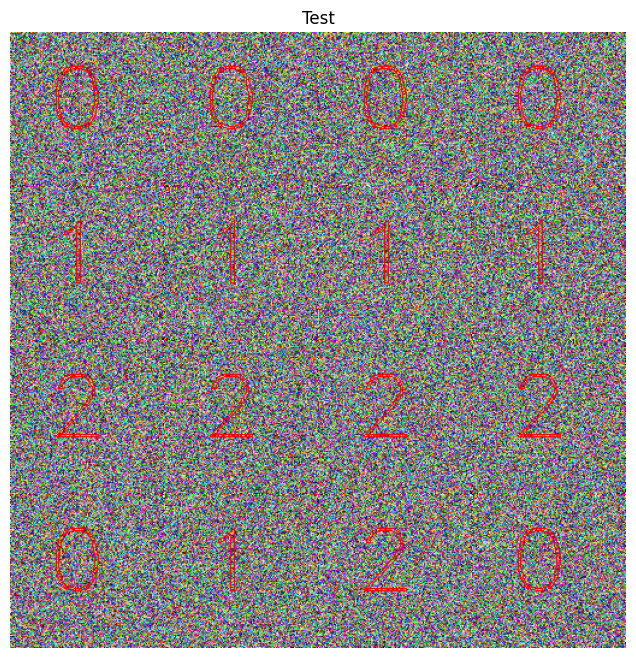

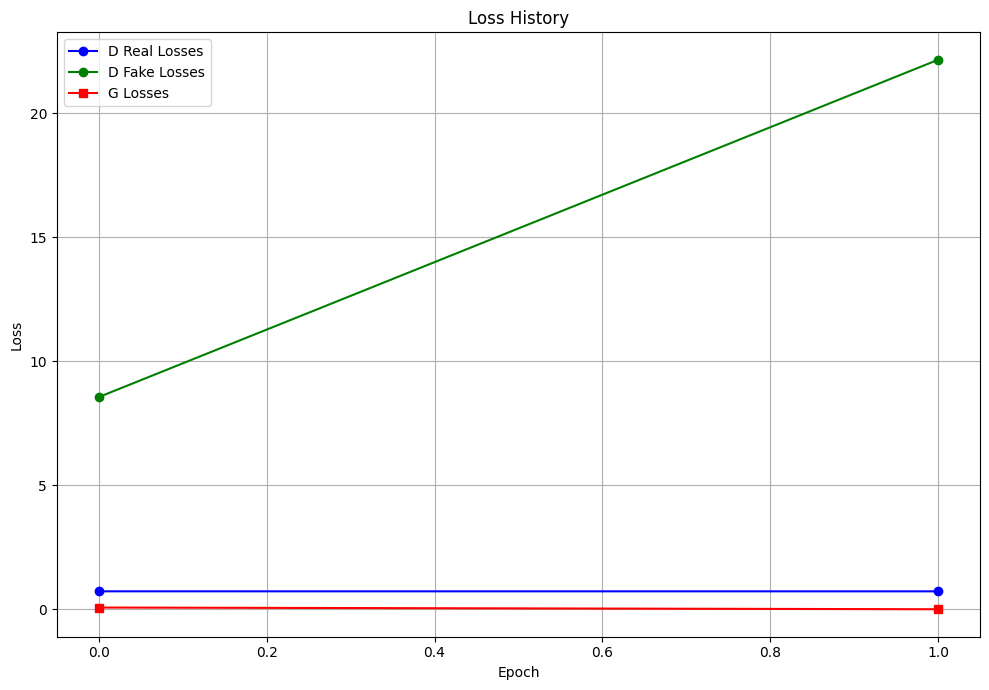

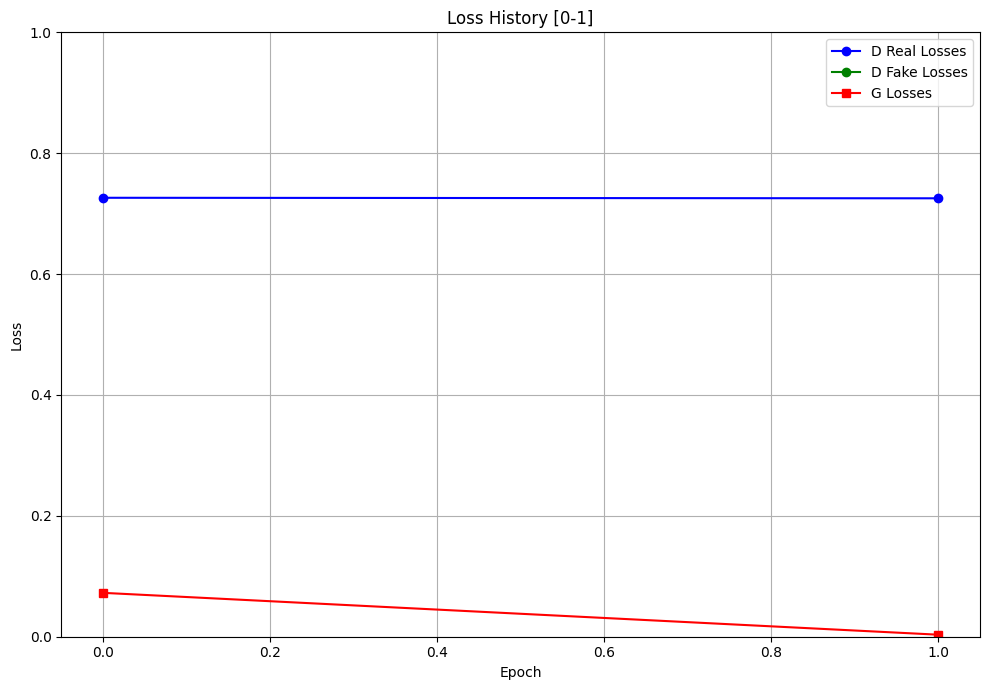

D_LOSS_REAL 0.7253853680659696
D_LOSS_FAKE 22.158984278171797
G_LOSS 0.0033461575514678325
EPOCH 2 SESSION


 25%|██▌       | 230/914 [00:26<01:18,  8.75it/s]

BATCH 228
d_loss_fake:  24.868312327622327  d_loss_real:  0.7258057086748848  g_loss:  0.0020931759345329017


 50%|█████     | 458/914 [00:52<00:51,  8.81it/s]

BATCH 456
d_loss_fake:  25.318235898174393  d_loss_real:  0.7261793190853861  g_loss:  0.0025425535713290482


 75%|███████▌  | 686/914 [01:20<00:30,  7.44it/s]

BATCH 684
d_loss_fake:  25.644730819924906  d_loss_real:  0.7260307608729731  g_loss:  0.002467640894228414


 91%|█████████ | 832/914 [01:39<00:10,  7.82it/s]

In [ ]:
train(gan,discriminator,generator,dataloader.dataset,session_metrics,test_noises,test_labels)

## TRANSFER MODEL

## TESTS

In [19]:
test_noises,test_labels = get_test_input()

gnrtd_imgs = models.test_generator(test_noises,test_labels)
interval_test_sample = get_inter_test_sample(gnrtd_imgs,test_labels)

1/1 [==============================] - 0s 20ms/step


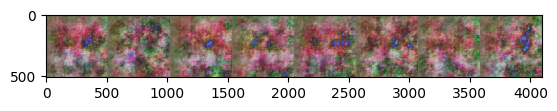

In [20]:
import matplotlib.pyplot as plt 
plt.imshow(interval_test_sample)